In [11]:
### helper functions

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import normalize
import os
import numpy as np
from typing import List, Tuple
import pandas as pd
import importlib

from utils import io_helpers, evaluation

importlib.reload(io_helpers)

documents = io_helpers.get_documents(print_info=True, read_embeddings=True)

filtered_docs = documents[documents["original_doc_ids"].apply(lambda x: len(x) > 0)]

# original docs: 108
# manipulated textual docs: 30
# manipulated tabular docs: 3
# manipulated textual multi docs: 30
= 171 documents in total


## Create Document Embeddings


In [12]:
### Get embeddings
from openai import OpenAI, RateLimitError
from dotenv import load_dotenv
from tenacity import retry, retry_if_exception_type, wait_random, stop_after_attempt
import csv

load_dotenv("/Users/leon/.env")
client = OpenAI()

FILEPATH = "data/additional_data/docs/_embeddings.csv"
FIELDNAMES = ["doc_id", "content", "embedding"]


def get_embeddings(input: str) -> List[float]:
    print("DEBUG: Getting embedding from OpenAI")
    embedding = client.embeddings.create(model="text-embedding-3-small", input=input, encoding_format="float")
    print(f"DEBUG: Got embedding. Usage: {embedding.usage.total_tokens} total tokens.")
    return embedding.data[0].embedding


@retry(
    retry=retry_if_exception_type(RateLimitError),
    wait=wait_random(min=30, max=60),
    stop=stop_after_attempt(6),
)
def get_and_save_embeddings(row) -> None:
    docs_processed = pd.read_csv(FILEPATH, usecols=["doc_id"])["doc_id"].to_list()
    if row["doc_id"] in docs_processed:
        print(f"Doc with ID '{row["doc_id"]}' has been processed before.")
        return

    embedding = get_embeddings(row["content"])
    with open(FILEPATH, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=FIELDNAMES)
        writer.writerow({"doc_id": row["doc_id"], "content": row["content"], "embedding": embedding})

In [ ]:
# _ = documents.apply(get_and_save_embeddings, axis=1)

print("Done")

## k-means


In [13]:
### k-means

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from utils import evaluation, io_helpers


def kmeans_cluster_embeddings(df: pd.DataFrame, column_name: str = "cluster", n_clusters: int = 108) -> pd.DataFrame:
    """
    Applies KMeans clustering to a column of document embeddings in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the embeddings.
    - n_clusters: int, number of clusters to form (default is 108).

    Returns:
    - df: original DataFrame with an added column 'cluster' containing cluster labels.
    """
    # Extract embeddings and convert to NumPy array
    embeddings = np.vstack(df["embedding"].values)

    # Run KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Add the labels back to the DataFrame
    df[column_name] = [[label] for label in cluster_labels]

    return df


documents = io_helpers.get_documents(read_embeddings=True)
documents = kmeans_cluster_embeddings(df=documents, column_name="cluster")
documents, recall = evaluation.evaluate_clusters(documents, "cluster")
num_avg_related_docs = evaluation.count_avg_related_docs(documents, "cluster")

print(f"Recall: {round(recall, 4)*100}%")
print(f"Avg. related docs {num_avg_related_docs:.2f}")

filtered_documents = documents.loc[documents["original_doc_ids"].notna()]
filtered_documents

Recall: 42.22%
Avg. related docs 1.97


/Users/leon/miniconda3/envs/ma/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/leon/miniconda3/envs/ma/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,doc_id,domain,content,original_doc_ids,embedding,cluster,cluster_hitrate
0,40,Finance,Acme Government Solutions is a government indu...,[],"[0.035415836, 0.015197343, 0.08163272, 0.02999...",[35],NaN
1,41,Finance,Entertainment Enterprises Inc. is an entertain...,[],"[0.050379667, -0.0005295727, 0.04373168, 0.038...",[8],NaN
2,42,Finance,"Advanced Manufacturing Solutions Inc., establi...",[],"[0.023992022, 0.011302027, 0.050733544, 0.0336...",[39],NaN
3,43,Finance,"EcoGuard Solutions, established on April 15, 2...",[],"[0.0594782, 0.01698723, 0.061538648, 0.0547162...",[100],NaN
4,44,Finance,"Green Fields Agriculture Ltd., established on ...",[],"[0.017018009, 0.014309261, 0.082911275, 0.0502...",[17],NaN
...,...,...,...,...,...,...,...
166,400116,Law,In a significant legal proceeding at the Cedar...,[116],"[0.028841885, -0.034240857, 0.044584155, 0.031...",[97],0.0
167,400059,Finance,"Retail Emporium, a well-established retail gia...",[59],"[0.03652241, 0.02207698, 0.021544848, 0.039533...",[9],1.0
168,300002,Finance,Month and year when Entertainment Enterprises ...,"[41, 44, 46, 49, 54, 55, 62, 67, 69, 71]","[-0.0074644033, -0.0027117808, 0.02252509, 0.0...",[51],0.0
169,300003,Law,Amount embezzled by N. Adams in July 2022 acco...,"[111, 113, 119, 122, 123, 124, 129, 131, 135, ...","[0.010342025, 0.024066817, 0.002971097, 0.0210...",[65],0.0


## Fuzzy c-means


In [14]:
### Use algorithm from skfuzzy
import skfuzzy as fuzz


def skfuzzy_cmeans(
    df: pd.DataFrame, column_name_new: str = "clusters", n_clusters: int = 108, m: int = 2
) -> Tuple[pd.DataFrame, float]:
    """
    Applies c-means clustering to a column of document embeddings in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the embeddings.
    - n_clusters: int, number of clusters to form (default is 108).

    Returns:
    - df: original DataFrame with an added column 'cluster' containing cluster memberships.
    """
    # Extract embeddings and convert to NumPy array
    embeddings = np.vstack(df["embedding"].values).transpose()

    # Run c-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data=embeddings, c=n_clusters, m=m, error=0.005, maxiter=1000, metric="euclidean", init=None
    )

    membership: np.ndarray = u.transpose()

    # Add the labels back to the DataFrame
    df[column_name_new] = [list(ms) for ms in membership]

    out = (df, fpc)
    return out

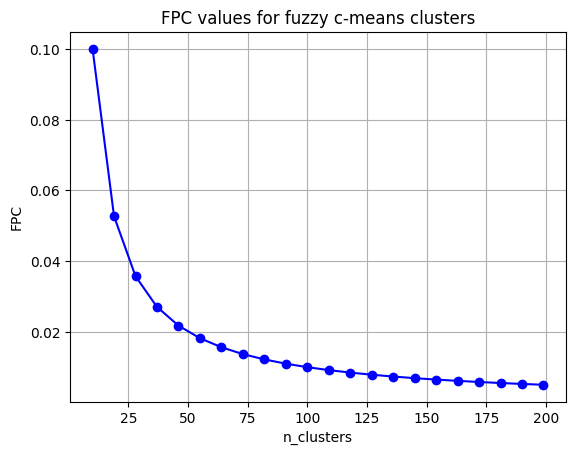

In [15]:
### select best no. of clusters by FPC
import matplotlib.pyplot as plt

max = 200
min = 10
num_steps = 20
step_size = int((max - min) / num_steps)
n_clusters = range(min, max, step_size)

fpcs = []
f_values = {}

for n in n_clusters:
    _, fpc = skfuzzy_cmeans(documents, column_name_new="membership", n_clusters=n)
    fpcs.append(fpc)
    f_values.update({n: fpc})

best_n = n_clusters[np.argmax(fpcs)]

x_vals = sorted(f_values.keys())
y_vals = [f_values[x] for x in x_vals]

# Plotting
plt.plot(x_vals, y_vals, marker="o", linestyle="-", color="blue")
plt.title("FPC values for fuzzy c-means clusters")
plt.xlabel("n_clusters")
plt.ylabel("FPC")
plt.grid(True)
plt.show()

In [25]:
### Apply algorithm and evaluate results
from utils import evaluation

importlib.reload(evaluation)


def select_for_cumulative_threshold(membership, threshold=0.9):
    membership = np.array(membership)
    sorted_indices = np.argsort(membership)[::-1]

    # Sort the probabilities accordingly
    sorted_probs = membership[sorted_indices]

    # Compute cumulative sum
    cumulative = np.cumsum(sorted_probs)

    # Find the cutoff index where cumulative sum first exceeds threshold
    cutoff = np.searchsorted(cumulative, threshold)

    # Select the indices up to and including that point
    selected_indices = sorted_indices[: cutoff + 1]

    return selected_indices.tolist()


documents = io_helpers.get_documents(read_embeddings=True)

documents, fpc = skfuzzy_cmeans(documents, column_name_new="membership", n_clusters=108)
documents["clusters"] = documents["membership"].apply(select_for_cumulative_threshold, args=(0.014,))
documents, recall, recall_without_tabular = evaluation.evaluate_clusters(documents, "clusters", True)
num_avg_related_docs = evaluation.count_avg_related_docs(documents, "clusters")

print(f"FPC: {fpc:.6f}")
print(f"Recall: {recall * 100:.2f} %")
print(f"Recall without tabular docs: {recall_without_tabular * 100:.2f} %")
print(f"Avg. related docs {num_avg_related_docs:.2f}")

filtered_documents = documents.loc[documents["original_doc_ids"].notna()]

filtered_documents

FPC: 0.009273
Recall: 100.00 %
Recall without tabular docs: 100.00 %
Avg. related docs 57.37


/Users/leon/miniconda3/envs/ma/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/leon/miniconda3/envs/ma/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,doc_id,domain,content,original_doc_ids,embedding,membership,clusters,clusters_hitrate
0,40,Finance,Acme Government Solutions is a government indu...,[],"[0.035415836, 0.015197343, 0.08163272, 0.02999...","[0.008818752007797045, 0.009134529542948794, 0...","[56, 92]",NaN
1,41,Finance,Entertainment Enterprises Inc. is an entertain...,[],"[0.050379667, -0.0005295727, 0.04373168, 0.038...","[0.008804736811880067, 0.009132329849365215, 0...","[56, 92]",NaN
2,42,Finance,"Advanced Manufacturing Solutions Inc., establi...",[],"[0.023992022, 0.011302027, 0.050733544, 0.0336...","[0.008848965412471745, 0.009140044165951449, 0...","[56, 92]",NaN
3,43,Finance,"EcoGuard Solutions, established on April 15, 2...",[],"[0.0594782, 0.01698723, 0.061538648, 0.0547162...","[0.008814132429038087, 0.009129388389798583, 0...","[56, 92]",NaN
4,44,Finance,"Green Fields Agriculture Ltd., established on ...",[],"[0.017018009, 0.014309261, 0.082911275, 0.0502...","[0.008830666995470976, 0.009127347346103074, 0...","[56, 92]",NaN
...,...,...,...,...,...,...,...,...
166,400116,Law,In a significant legal proceeding at the Cedar...,[116],"[0.028841885, -0.034240857, 0.044584155, 0.031...","[0.009423589388739688, 0.00943297000733396, 0....","[66, 29]",1.0
167,400059,Finance,"Retail Emporium, a well-established retail gia...",[59],"[0.03652241, 0.02207698, 0.021544848, 0.039533...","[0.009048712903314656, 0.00922482053992141, 0....","[56, 92]",1.0
168,300002,Finance,Month and year when Entertainment Enterprises ...,"[41, 44, 46, 49, 54, 55, 62, 67, 69, 71]","[-0.0074644033, -0.0027117808, 0.02252509, 0.0...","[0.00898056676511933, 0.009187057723112685, 0....","[56, 92]",1.0
169,300003,Law,Amount embezzled by N. Adams in July 2022 acco...,"[111, 113, 119, 122, 123, 124, 129, 131, 135, ...","[0.010342025, 0.024066817, 0.002971097, 0.0210...","[0.009413795375297627, 0.009416439905731292, 0...","[66, 29]",1.0


## Distance-based

Distances:

-   euclidean
-   cosine
-   (manhatten)
-   (dot product)


In [5]:
### Explore distances in dataset
from typing import Literal
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances


def calc_pairwise_distances(X, metric: Literal["cosine", "euclidean"] = "cosine"):
    if metric == "cosine":
        return cosine_distances(X)
    if metric == "euclidean":
        return euclidean_distances(X)


def describe_distances(distances):
    mask = ~np.isclose(distances, 0, atol=1e-8)  # filter out 0s
    filtered_values = distances[mask]
    max_value = filtered_values.max()
    min_value = filtered_values.min()
    mean_value = filtered_values.mean()

    print("- Distances --")
    print(f"Min: {min_value:.6f}")
    print(f"Max: {max_value:.6f}")
    print(f"Mean: {mean_value:.6f}")
    print("--------------")
    print()

### Cosine


In [11]:
### calc similarity based on cosine distances
importlib.reload(evaluation)

documents = io_helpers.get_documents(read_embeddings=True)
X = [np.asarray(embedding) for embedding in documents["embedding"]]

distances_cosine = calc_pairwise_distances(X, "cosine")
describe_distances(distances_cosine)


threshold = 0.25
recall = 0.0

while recall < 0.99:
    documents_tmp = documents.copy()
    documents_tmp["distances"] = [distance_arr.tolist() for distance_arr in distances_cosine]
    documents_tmp, recall, avg_comparisons, recall_without_tabular = evaluation.evaluate_distances(
        documents_tmp, "distances", threshold, True
    )

    print(f"- Threshold = {threshold} -")
    print(f"Recall: {recall*100:.2f} %")
    print(f"Recall without tabular: {recall_without_tabular*100:.2f} %")
    print(f"Average no. of comparisons: {avg_comparisons:.1f}")
    print()

    threshold = round(threshold + 0.05, 2)

- Distances --
Min: 0.000001
Max: 0.970187
Mean: 0.613882
--------------

- Threshold = 0.25 -
Recall: 57.78 %
Recall without tabular: 86.67 %
Average no. of comparisons: 5.9

- Threshold = 0.3 -
Recall: 61.11 %
Recall without tabular: 91.67 %
Average no. of comparisons: 16.9

- Threshold = 0.35 -
Recall: 67.78 %
Recall without tabular: 100.00 %
Average no. of comparisons: 30.4

- Threshold = 0.4 -
Recall: 72.22 %
Recall without tabular: 100.00 %
Average no. of comparisons: 37.7

- Threshold = 0.45 -
Recall: 83.33 %
Recall without tabular: 100.00 %
Average no. of comparisons: 42.2

- Threshold = 0.5 -
Recall: 87.78 %
Recall without tabular: 100.00 %
Average no. of comparisons: 47.2

- Threshold = 0.55 -
Recall: 96.67 %
Recall without tabular: 100.00 %
Average no. of comparisons: 52.8

- Threshold = 0.6 -
Recall: 98.89 %
Recall without tabular: 100.00 %
Average no. of comparisons: 57.4

- Threshold = 0.65 -
Recall: 100.00 %
Recall without tabular: 100.00 %
Average no. of comparisons: 63

In [8]:
### calc cosine similarity and save
import csv
import importlib

importlib.reload(evaluation)

FIELDNAMES = ["doc_id", "related_docs"]

documents = io_helpers.get_documents(read_embeddings=True)
X = [np.asarray(embedding) for embedding in documents["embedding"]]
distances_cosine = calc_pairwise_distances(X, "cosine")

threshold = 0.61

documents["distances"] = [distance_arr.tolist() for distance_arr in distances_cosine]
documents, recall, avg_comparisons, recall_without_tabular = evaluation.evaluate_distances(
    documents, "distances", threshold, True
)

print(f"- Threshold = {threshold} -")
print(f"Recall: {recall*100:.2f} %")
print(f"Recall without tabular: {recall_without_tabular*100:.2f} %")
print(f"Average no. of comparisons: {avg_comparisons:.1f}")
print()

doc_relation_path = "data/additional_data/docs/_relations.csv"
try:
    documents.to_csv(doc_relation_path, columns=["doc_id", "related_docs"], index=False, mode="x")
    print(f"Document relations saved to '{doc_relation_path}'.")
except FileExistsError:
    print(f"File '{doc_relation_path}' already exists. Did nothing.")


filtered_documents = documents.loc[documents["original_doc_ids"].apply(lambda x: len(x) != 0)]
filtered_documents

- Threshold = 0.61 -
Recall: 100.00 %
Recall without tabular: 100.00 %
Average no. of comparisons: 57.9

File 'data/additional_data/docs/_relations.csv' already exists. Did nothing.


,doc_id,domain,content,original_doc_ids,embedding,distances,related_docs,hitrate
108,100046,Finance,"JetWing Aviation, established on April 15, 200...",[46],"[-0.009702898, 0.0164151, 0.06840374, 0.018056...","[0.324951031106838, 0.34136523021163423, 0.422...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5...",1.0
109,100071,Finance,"ABC Education Corporation, a publicly listed c...",[71],"[0.044830333, 0.004590988, 0.062358502, 0.0741...","[0.26035358388121654, 0.26489966152960853, 0.3...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5...",1.0
110,100208,Medical,Hospitalization Record\n\nBasic Information:\n...,[208],"[0.023437671, -0.00015391731, -0.008652046, 0....","[0.7645287728994794, 0.7650131180964249, 0.777...","[126, 127, 178, 179, 180, 181, 182, 183, 184, ...",1.0
111,100119,Law,"**RIVERTON, HAMILTON COURT CRIMINAL JUDGMENT**...",[119],"[0.029815592, 0.0013786607, 0.009239766, 0.024...","[0.7652434242004592, 0.7741228503008772, 0.740...","[110, 111, 112, 113, 114, 115, 116, 117, 118, ...",1.0
112,100123,Law,**Sterling Quarryville Court**\n\n**Sterling Q...,[123],"[0.050201856, 0.024881259, -0.02854242, 0.0409...","[0.7627284718907248, 0.7264135629781315, 0.721...","[110, 111, 112, 113, 114, 115, 116, 117, 118, ...",1.0
...,...,...,...,...,...,...,...,...
166,400116,Law,In a significant legal proceeding at the Cedar...,[116],"[0.028841885, -0.034240857, 0.044584155, 0.031...","[0.7600469183295613, 0.737594015546366, 0.7583...","[110, 111, 112, 113, 114, 115, 116, 117, 118, ...",1.0
167,400059,Finance,"Retail Emporium, a well-established retail gia...",[59],"[0.03652241, 0.02207698, 0.021544848, 0.039533...","[0.5733847399947818, 0.4527101582518146, 0.515...","[40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 5...",1.0
168,300002,Finance,Month and year when Entertainment Enterprises ...,"[41, 44, 46, 49, 54, 55, 62, 67, 69, 71]","[-0.0074644033, -0.0027117808, 0.02252509, 0.0...","[0.48678790087470536, 0.42222448744260754, 0.4...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5...",1.0
169,300003,Law,Amount embezzled by N. Adams in July 2022 acco...,"[111, 113, 119, 122, 123, 124, 129, 131, 135, ...","[0.010342025, 0.024066817, 0.002971097, 0.0210...","[0.7530845053792101, 0.7294648598220597, 0.719...","[110, 111, 112, 113, 114, 115, 116, 117, 118, ...",1.0


### Euclidean


In [13]:
### calc similarity based on euclidean distance
importlib.reload(evaluation)

documents = io_helpers.get_documents(read_embeddings=True)
X = [np.asarray(embedding) for embedding in documents["embedding"]]

distances_euclidean = calc_pairwise_distances(X, "euclidean")

describe_distances(distances_euclidean)

threshold = 0.8
recall = 0.0

while recall < 0.99:
    documents_tmp = documents.copy()
    documents_tmp["distances"] = [distance_arr.tolist() for distance_arr in distances_euclidean]
    documents_tmp, recall, avg_comparisons, recall_without_tabular = evaluation.evaluate_distances(
        documents_tmp, "distances", threshold, True
    )

    print(f"- Threshold = {threshold} -")
    print(f"Recall: {recall*100:.2f} %")
    print(f"Recall without tabular: {recall_without_tabular*100:.2f} %")
    print(f"Average no. of comparisons: {avg_comparisons:.1f}")
    print()

    threshold = round(threshold + 0.05, 2)

- Distances --
Min: 0.001211
Max: 1.392973
Mean: 1.090355
--------------

- Threshold = 0.8 -
Recall: 63.33 %
Recall without tabular: 95.00 %
Average no. of comparisons: 23.0

- Threshold = 0.85 -
Recall: 67.78 %
Recall without tabular: 100.00 %
Average no. of comparisons: 32.5

- Threshold = 0.9 -
Recall: 74.44 %
Recall without tabular: 100.00 %
Average no. of comparisons: 38.4

- Threshold = 0.95 -
Recall: 83.33 %
Recall without tabular: 100.00 %
Average no. of comparisons: 42.3

- Threshold = 1.0 -
Recall: 87.78 %
Recall without tabular: 100.00 %
Average no. of comparisons: 47.2

- Threshold = 1.05 -
Recall: 96.67 %
Recall without tabular: 100.00 %
Average no. of comparisons: 53.0

- Threshold = 1.1 -
Recall: 98.89 %
Recall without tabular: 100.00 %
Average no. of comparisons: 57.5

- Threshold = 1.15 -
Recall: 100.00 %
Recall without tabular: 100.00 %
Average no. of comparisons: 66.8

